<a href="https://colab.research.google.com/github/Osman-Dawood/Assinment-2/blob/main/Lab5assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TIME SERIES FORECASTING USING RNNS


Missing Values After Imputation:
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


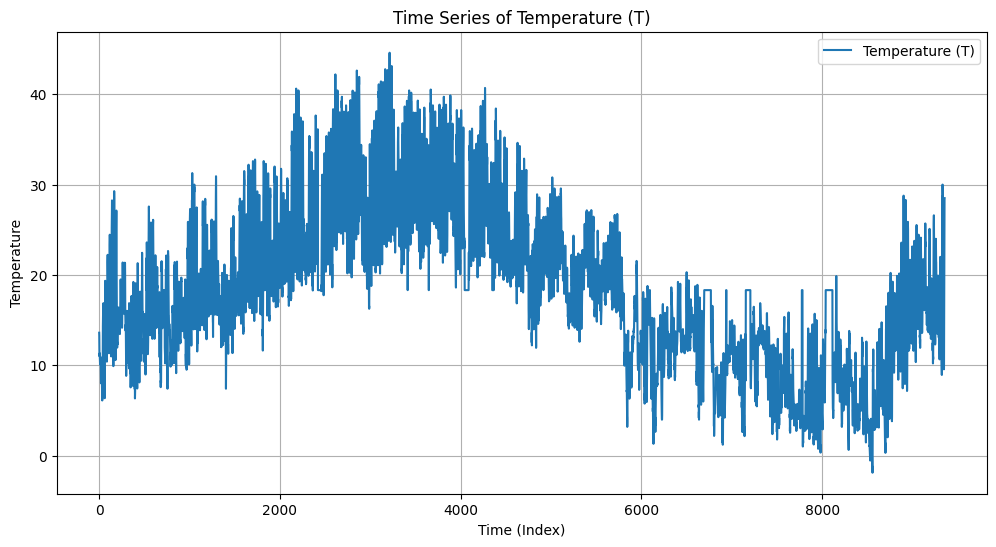

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import requests
import zipfile
import io

# Step 1: Install openpyxl for reading Excel files (if not already installed)
!pip install openpyxl

# Step 2: Load dataset from Google Drive
file_id = "15HUU9eGYnZd0_s-EmO1l2rVc_fd26Ro5"
download_url = f"https://drive.google.com/uc?id={file_id}"
data = pd.read_excel(download_url)

# Step 3: Handle missing values
data.replace(-200, np.nan, inplace=True)  # Replace -200 with NaN
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())  # Impute missing values
print("\nMissing Values After Imputation:")
print(data.isnull().sum())

# Step 4: Process 'Date' and 'Time' columns
data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' to datetime objects
data['Year'], data['Month'], data['Day'] = data['Date'].dt.year, data['Date'].dt.month, data['Date'].dt.day
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))  # Combine Date & Time
data['Datetime'] = pd.to_numeric(data['Datetime'])  # Convert to numeric for modeling

# Drop unnecessary columns after processing
data = data.drop(['Date', 'Time', 'Year', 'Month', 'Day'], axis=1)

# Step 5: Select features and target
# Remove all columns containing 'GT' except 'C6H6(GT)'
Model_data = data.loc[:, ~data.columns.str.contains('GT', case=False) | (data.columns == 'C6H6(GT)')]

# Extract Temperature (T) as the target and drop it from features
T = Model_data['T'].values.reshape(-1, 1)  # Target
Model_data = Model_data.drop(columns=['T'])  # Features

# Step 6: Normalize features and target
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(Model_data)
scaled_target = scaler.fit_transform(T)

# Step 7: Create sequences for RNN
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 720  # Past 720 steps (30 days of hourly data)
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

# Step 8: Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape for RNN input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Step 9: Visualize the time series of Temperature (T)
plt.figure(figsize=(12, 6))
plt.plot(range(len(T)), T, label="Temperature (T)")
plt.xlabel("Time (Index)")
plt.ylabel("Temperature")
plt.title("Time Series of Temperature (T)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
X_train.shape, y_train.shape

((6909, 720, 9), (6909, 1))

#SimpleRNN

##One-step ahead Forecasting.

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 37s 148ms/step - loss: 0.0338 - val_loss: 0.0048
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 152ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 47s 143ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 12/20
216/216

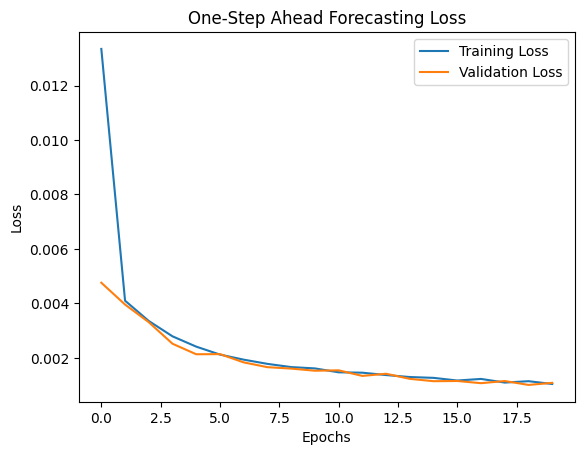

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense

# One-step ahead forecasting model
model_one_step = Sequential([
    Input(shape=(None, X_train.shape[2])),  # Input layer
    SimpleRNN(20, return_sequences=False),  # RNN outputs only the last time step
    Dense(1)  # Single output for one-step forecasting
])

# Compile and train the model
model_one_step.compile(loss="mse", optimizer="adam")
history_one_step = model_one_step.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_valid, y_valid),
    batch_size=32
)

# Plot training and validation loss for one-step forecasting
plt.plot(history_one_step.history['loss'], label='Training Loss')
plt.plot(history_one_step.history['val_loss'], label='Validation Loss')
plt.title("One-Step Ahead Forecasting Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



##Multi-step Forecasting Model


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - loss: 0.1943 - val_loss: 0.0104
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 37s 172ms/step - loss: 0.0092 - val_loss: 0.0064
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 127ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/20
216/216

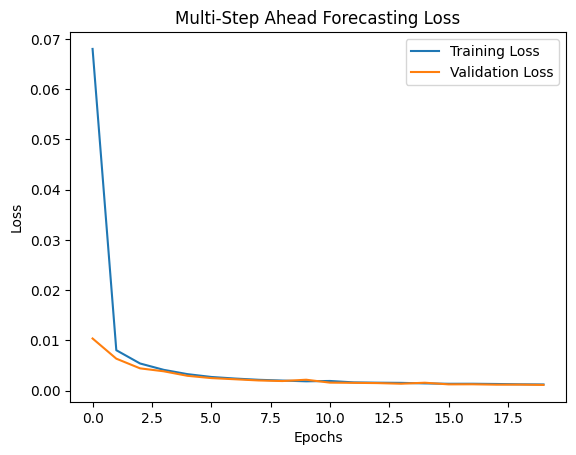

In [ ]:

model_multi_step = Sequential([
    Input(shape=(None, X_train.shape[2])),  # Input layer
    SimpleRNN(20, return_sequences=False),  # RNN outputs a single prediction
    Dense(5)  # Predicts 5 future steps directly
])

# Compile and train the model
model_multi_step.compile(loss="mse", optimizer="adam")
history_multi_step = model_multi_step.fit(
    X_train, y_train[:, :10],  # Adjust labels for multi-step forecasting
    epochs=20,
    validation_data=(X_valid, y_valid[:, :10]),
    batch_size=32
)

# Plot training and validation loss for multi-step forecasting
plt.plot(history_multi_step.history['loss'], label='Training Loss')
plt.plot(history_multi_step.history['val_loss'], label='Validation Loss')
plt.title("Multi-Step Ahead Forecasting Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


#Deep RNN
##One-step ahead Forecasting.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 107s 474ms/step - loss: 0.2449 - val_loss: 0.0084
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 99s 457ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 142s 455ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 143s 461ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 142s 461ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 141s 458ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 100s 462ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 142s 462ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 141s 458ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 99s 455ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 109s 504ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 12/2

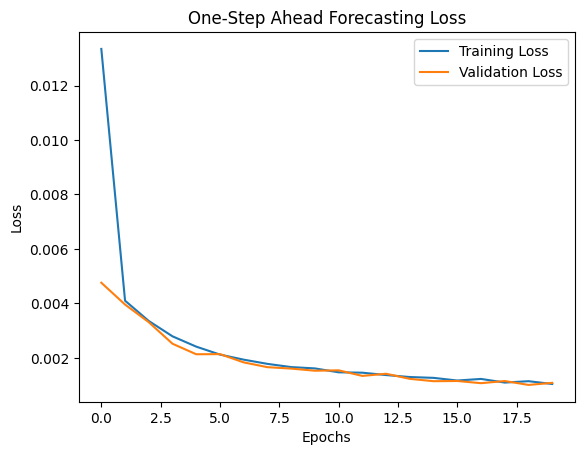

In [20]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 9]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

# Plot training and validation loss for one-step forecasting
plt.plot(history_one_step.history['loss'], label='Training Loss')
plt.plot(history_one_step.history['val_loss'], label='Validation Loss')
plt.title("One-Step Ahead Forecasting Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Deep RNN with Batch Normalization

In [56]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Custom metric for last time step MSE
def last_time_step_mse(y_true, y_pred):
    """
    Custom metric function to calculate MSE for the last time step.

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values from the model.
    Returns:
        Mean Squared Error for the last time step.
    """
    # Ensure the input is 3D and sliceable for the last time step
    y_true_last = y_true[:, -1]
    y_pred_last = y_pred[:, -1]
    # Use tf.keras.losses.MSE instead of tf.keras.losses.mean_squared_error
    return tf.reduce_mean(tf.keras.losses.MSE(y_true_last, y_pred_last))

# Deep RNN with Batch Normalization using Input layer
# Deep RNN with Batch Normalization
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 9]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(1) # Changed this line to output a single value
    ])

# Compile the model
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

# Ensure X_train and y_train have the correct shapes for time-series data
# X_train: (samples, timesteps, features), y_train: (samples, timesteps, targets)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 109s 481ms/step - last_time_step_mse: 0.3099 - loss: 0.3099 - val_last_time_step_mse: 0.1971 - val_loss: 0.1971
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 143s 489ms/step - last_time_step_mse: 0.0293 - loss: 0.0293 - val_last_time_step_mse: 0.0666 - val_loss: 0.0666
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 140s 479ms/step - last_time_step_mse: 0.0170 - loss: 0.0170 - val_last_time_step_mse: 0.0084 - val_loss: 0.0084
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 493ms/step - last_time_step_mse: 0.0099 - loss: 0.0099 - val_last_time_step_mse: 0.0061 - val_loss: 0.0061
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 140s 483ms/step - last_time_step_mse: 0.0083 - loss: 0.0083 - val_last_time_step_mse: 0.0473 - val_loss: 0.0473
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 143s 486ms/step - last_time_step_mse: 0.0134 - loss: 0.0134 - val_last_time_step_mse: 0.0049 - val_loss: 0.0049
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 106s 490ms/step - last_time_step_mse: 0.0133 - l

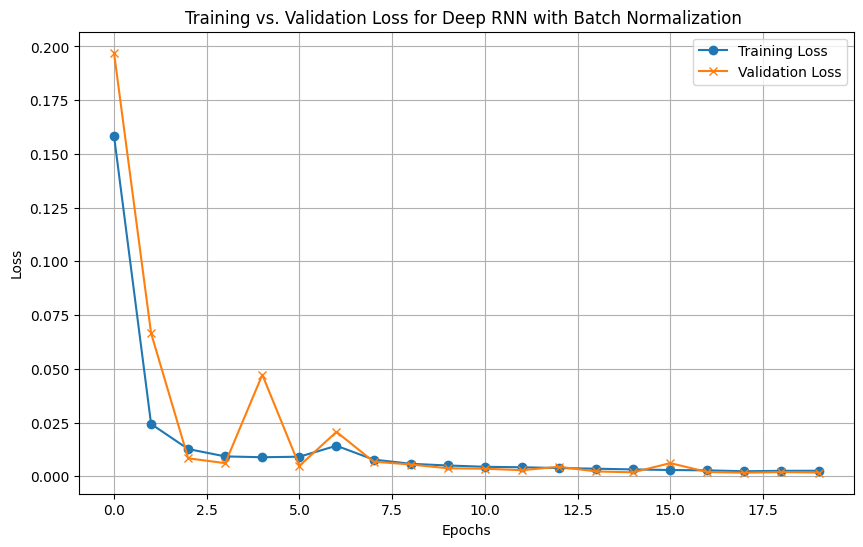

In [61]:
import matplotlib.pyplot as plt

# Plot training vs. validation loss
def plot_training_vs_validation_loss(history):
    """
    Plot training and validation loss from model training history.

    Args:
        history: Keras History object returned by model.fit().
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
    plt.title("Training vs. Validation Loss for Deep RNN with Batch Normalization ")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the training history
plot_training_vs_validation_loss(history)


#Deep RNN with Layer Normalization

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Custom metric for last time step MSE
def last_time_step_mse(y_true, y_pred):
    """
    Custom metric function to calculate MSE for the last time step.

    Args:
        y_true: Ground truth values.
        y_pred: Predicted values from the model.
    Returns:
        Mean Squared Error for the last time step.
    """
    # Ensure the input is 3D and sliceable for the last time step
    y_true_last = y_true[:, -1]  # Assuming y_true is 2D (samples, timesteps)
    y_pred_last = y_pred[:, -1]  # Assuming y_pred is 2D (samples, timesteps)

    # Calculate MSE using Keras backend functions for compatibility
    return tf.reduce_mean(tf.square(y_true_last - y_pred_last))

# Deep RNN with Layer Normalization
model_with_layer_norm = keras.models.Sequential([
    layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 9]),
    layers.LayerNormalization(),  # Layer Normalization after the first RNN layer
    layers.SimpleRNN(20, return_sequences=True),
    layers.LayerNormalization(),  # Layer Normalization after the second RNN layer
    layers.SimpleRNN(1)  # No layer normalization on the output layer
])

# Compile the model (remove the custom metric from compile)
model_with_layer_norm.compile(loss="mse", optimizer="adam")

# Ensure X_train and y_train have the correct shapes for time-series data
# X_train: (samples, timesteps, features), y_train: (samples, timesteps, targets)

# Train the model
history = model_with_layer_norm.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Calculate the custom metric after training (if needed)
y_pred = model_with_layer_norm.predict(X_test)
last_time_step_mse_value = last_time_step_mse(y_test, y_pred).numpy()
print("Last Time Step MSE:", last_time_step_mse_value)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 119s 494ms/step - loss: 0.0441 - val_loss: 0.0050
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 132s 452ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 140s 443ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 143s 449ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 137s 425ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 98s 453ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 140s 443ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 143s 452ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 98s 453ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 98s 454ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 142s 455ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/20

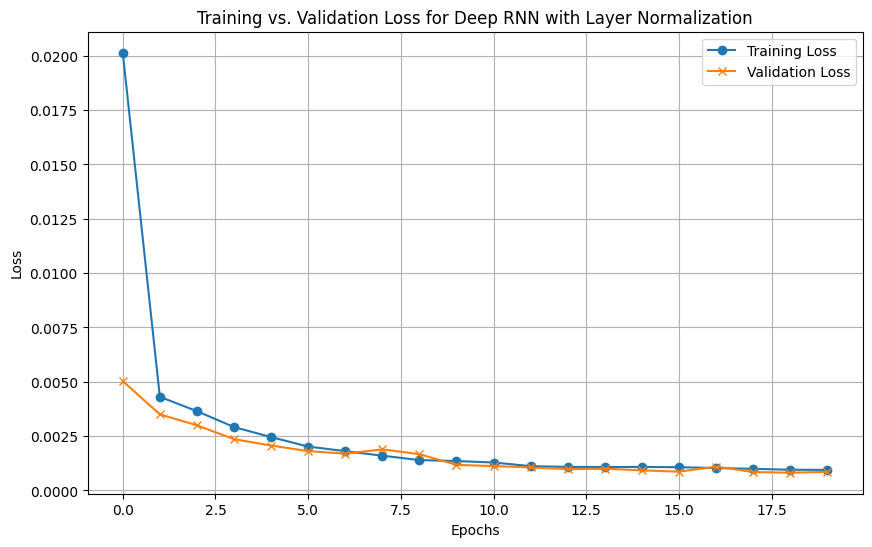

In [ ]:
import matplotlib.pyplot as plt

# Plot training vs. validation loss
def plot_training_vs_validation_loss(history):
    """
    Plot training and validation loss from model training history.

    Args:
        history: Keras History object returned by model.fit().
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
    plt.title("Training vs. Validation Loss for Deep RNN with Layer Normalization")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the training history
plot_training_vs_validation_loss(history)

# LSTM Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 155s 677ms/step - loss: 0.0258 - val_loss: 0.0036
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 201s 674ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 204s 682ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 202s 682ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 201s 678ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 201s 673ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 202s 672ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 202s 670ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 205s 686ms/step - loss: 0.0011 - val_loss: 9.7909e-04
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 146s 675ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 145s 670ms/step - loss: 9.2169e-04 - val_loss: 8.4906e

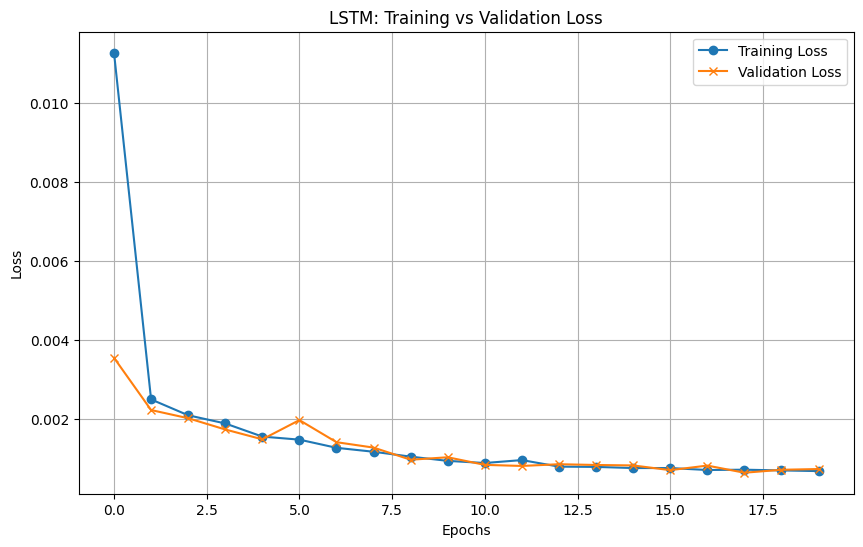

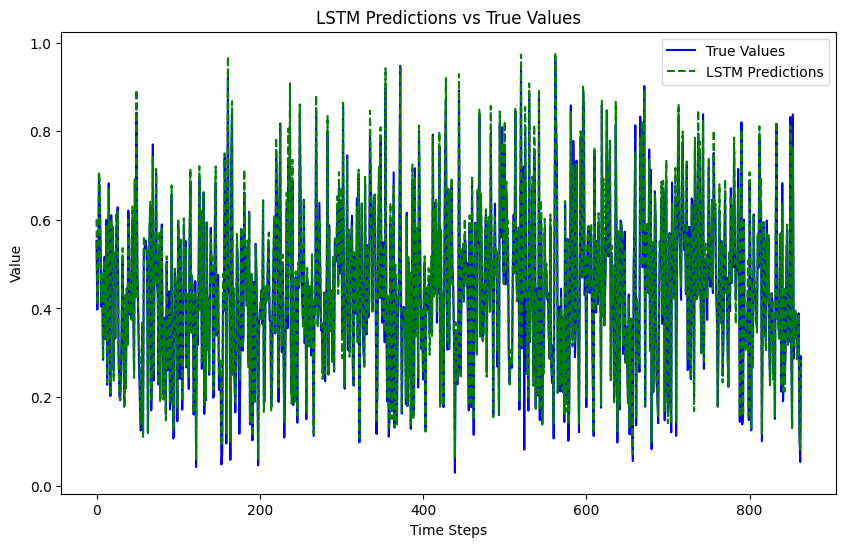

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Custom metric for last time step MSE
def last_time_step_mse(y_true, y_pred):
    """
    Custom metric function to calculate MSE for the last time step.
    """
    y_true_last = y_true[:, -1]  # Assuming y_true is 2D (samples, timesteps)
    y_pred_last = y_pred[:, -1]  # Assuming y_pred is 2D (samples, timesteps)
    return np.mean(np.square(y_true_last - y_pred_last))

# LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(None, 9)),  # 9 features as input
    LSTM(50),
    Dense(1)  # Single label as output
])

# Compile the LSTM model
model_lstm.compile(optimizer="adam", loss="mse")

# Train the LSTM model
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

# Evaluate the LSTM model
y_pred_lstm = model_lstm.predict(X_test)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

# Calculate last time step MSE for validation data
y_valid_pred = model_lstm.predict(X_valid)
val_last_time_step_mse = last_time_step_mse(y_valid, y_valid_pred)

print(f"LSTM RMSE: {rmse_lstm:.4f}")
print(f"LSTM R^2: {r2_lstm:.4f}")
print(f"Validation Last Time Step MSE: {val_last_time_step_mse:.4f}")

# Plot training vs validation loss for LSTM
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss', marker='o')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', marker='x')
plt.title("LSTM: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot LSTM predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values", color="blue")
plt.plot(y_pred_lstm, label="LSTM Predictions", color="green", linestyle="--")
plt.title("LSTM Predictions vs True Values")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


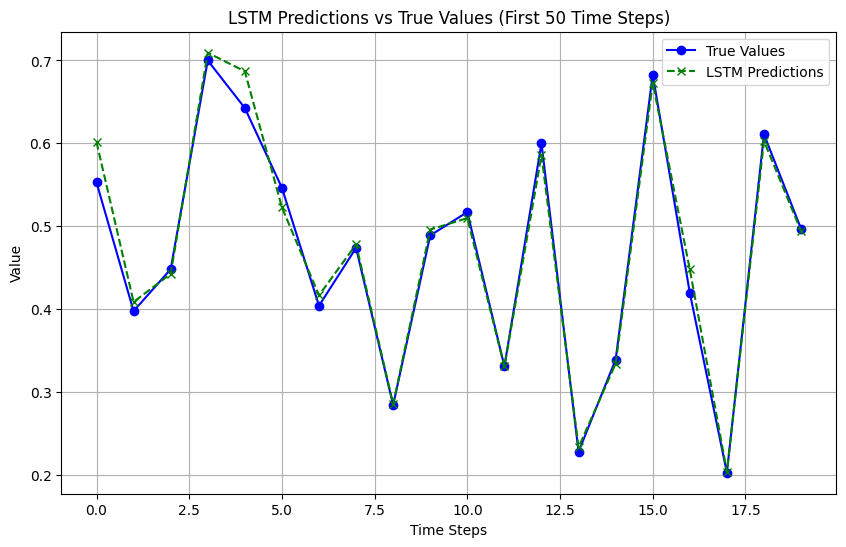

In [ ]:
# Plot LSTM predictions vs true values (First 20 Time Steps)
plt.figure(figsize=(10, 6))
plt.plot(y_test[:20], label="True Values", color="blue", marker='o')
plt.plot(y_pred_lstm[:20], label="LSTM Predictions", color="green", linestyle="--", marker='x')
plt.title("LSTM Predictions vs True Values (First 50 Time Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


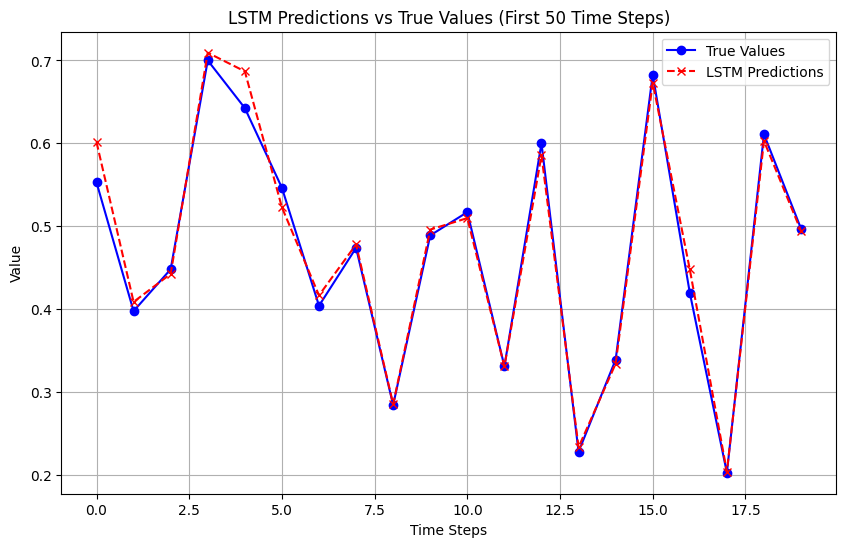

In [ ]:
# Plot LSTM predictions vs true values (First 20 Time Steps) with LSTM predictions in Red.
plt.figure(figsize=(10, 6))
plt.plot(y_test[:20], label="True Values", color="blue", marker='o')
plt.plot(y_pred_lstm[:20], label="LSTM Predictions", color="red", linestyle="--", marker='x')
plt.title("LSTM Predictions vs True Values (First 50 Time Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


# GRU Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 129s 582ms/step - loss: 0.0272 - val_loss: 0.0027
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 127s 587ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 129s 597ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 126s 583ms/step - loss: 0.0012 - val_loss: 9.3800e-04
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 126s 584ms/step - loss: 0.0011 - val_loss: 8.9243e-04
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 127s 590ms/step - loss: 0.0010 - val_loss: 8.3587e-04
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 128s 594ms/step - loss: 9.3984e-04 - val_loss: 9.1630e-04
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 125s 580ms/step - loss: 8.6996e-04 - val_loss: 0.0011
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 126s 585ms/step - loss: 9.1538e-04 - val_loss: 9.3678e-04
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 126s 582ms/step - loss: 8.5074e-04 - val_loss: 6.8254e-04
Epoch 11/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 124s 575ms/step - 

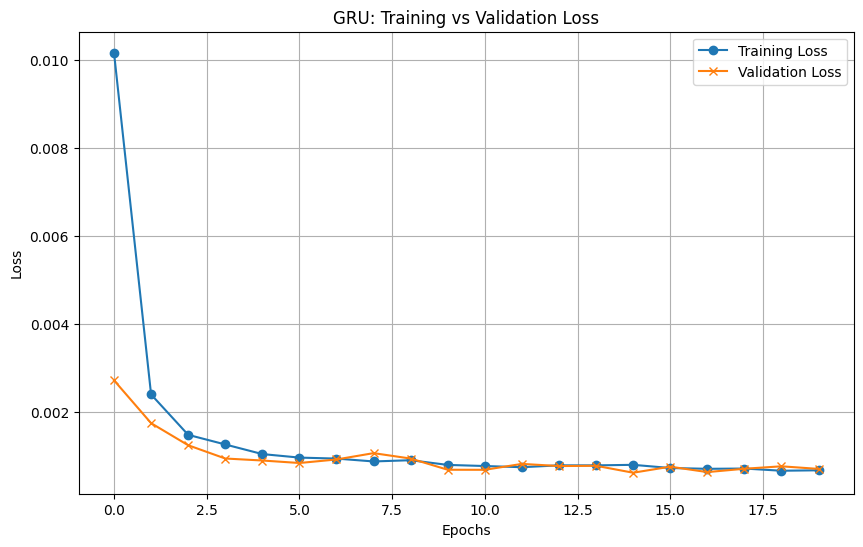

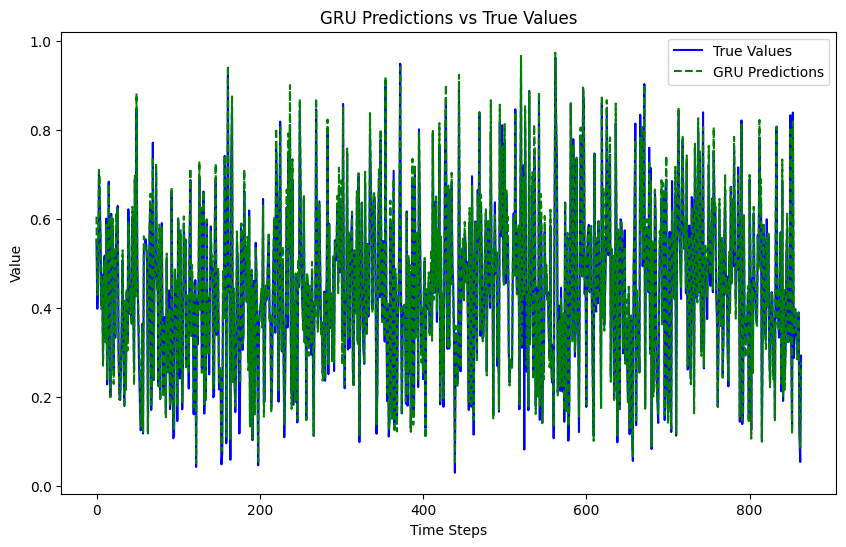

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Custom metric for last time step MSE
def last_time_step_mse(y_true, y_pred):
    """
    Custom metric function to calculate MSE for the last time step.
    """
    y_true_last = y_true[:, -1]  # Assuming y_true is 2D (samples, timesteps)
    y_pred_last = y_pred[:, -1]  # Assuming y_pred is 2D (samples, timesteps)
    return np.mean(np.square(y_true_last - y_pred_last))

# GRU Model
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(None, 9)),  # 9 features as input
    GRU(50),
    Dense(1)  # Single label as output
])

# Compile the GRU model
model_gru.compile(optimizer="adam", loss="mse")

# Train the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

# Evaluate the GRU model
y_pred_gru = model_gru.predict(X_test)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
r2_gru = r2_score(y_test, y_pred_gru)

# Calculate last time step MSE for validation data
y_valid_pred = model_gru.predict(X_valid)
val_last_time_step_mse = last_time_step_mse(y_valid, y_valid_pred)

print(f"GRU RMSE: {rmse_gru:.4f}")
print(f"GRU R^2: {r2_gru:.4f}")
print(f"Validation Last Time Step MSE: {val_last_time_step_mse:.4f}")

# Plot training vs validation loss for GRU
plt.figure(figsize=(10, 6))
plt.plot(history_gru.history['loss'], label='Training Loss', marker='o')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', marker='x')
plt.title("GRU: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot GRU predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values", color="blue")
plt.plot(y_pred_gru, label="GRU Predictions", color="green", linestyle="--")
plt.title("GRU Predictions vs True Values")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


#MUSIC GENERATION USING BATCH CHORALES DATASET

Loaded 229 training chorales, 76 validation chorales, 77 test chorales.
Training set: (47900, 32, 4), Validation set: (15976, 32, 4), Test set: (16436, 32, 4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 4, 5)          │             445 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, None, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, None, 32)            │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, None, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, None, 48)            │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, None, 48)            │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, None, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, None, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, None, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, None, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, None, 96)            │          12,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, None, 96)            │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, None, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         361,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 352)                 │          90,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 4, 88)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 476,365 (1.82 MB)

 Trainable params: 475,885 (1.82 MB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 244s 157ms/step - accuracy: 0.2067 - loss: 2.6150 - val_accuracy: 0.3878 - val_loss: 1.9903
Epoch 2/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 261s 157ms/step - accuracy: 0.3794 - loss: 1.9995 - val_accuracy: 0.4889 - val_loss: 1.7034
Epoch 3/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 261s 156ms/step - accuracy: 0.4528 - loss: 1.7636 - val_accuracy: 0.5194 - val_loss: 1.6121
Epoch 4/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 232s 155ms/step - accuracy: 0.4896 - loss: 1.6324 - val_accuracy: 0.5313 - val_loss: 1.5245
Epoch 5/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 233s 156ms/step - accuracy: 0.5138 - loss: 1.5514 - val_accuracy: 0.5582 - val_loss: 1.4636
Epoch 6/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 233s 155ms/step - accuracy: 0.5431 - loss: 1.4612 - val_accuracy: 0.5674 - val_loss: 1.4337
Epoch 7/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 258s 153ms/step - accuracy: 0.5587 - loss: 1.4098 - val_accuracy: 0.5639 - val_loss: 1.4334
Epoch 8/50
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 264s 154ms/step - ac

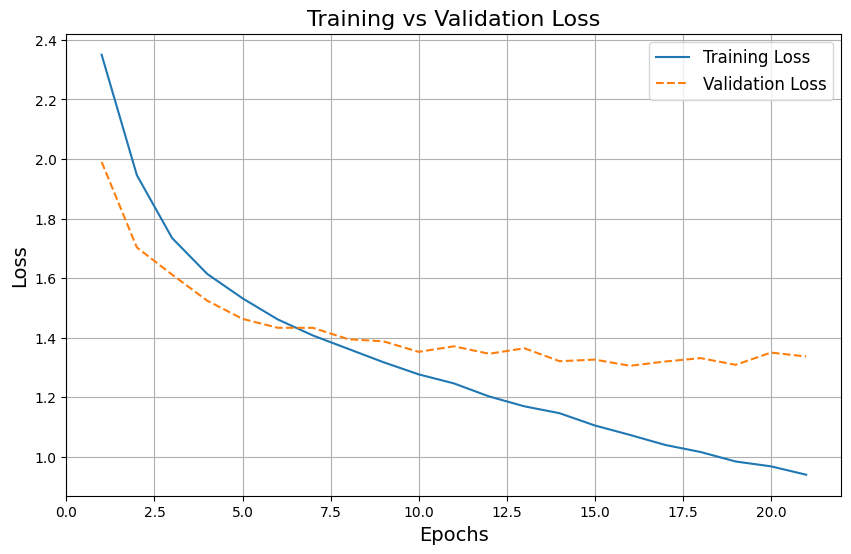

Generated Music Notes:
[65, 60, 57, 53]
[65, 60, 57, 53]
[65, 60, 57, 53]
[65, 60, 57, 53]
[72, 60, 55, 52]
[72, 60, 55, 52]
[70, 60, 55, 52]
[70, 60, 55, 52]
[69, 60, 53, 53]
[69, 60, 53, 53]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, BatchNormalization, Dropout
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, BatchNormalization, Dropout, Reshape # Import Reshape
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download and Load the Dataset
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(
    FILENAME, DOWNLOAD_ROOT + FILENAME, cache_subdir="datasets/jsb_chorales", extract=True
)
chorales_dir = Path(filepath).parent

train_files = sorted(chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(chorales_dir.glob("test/chorale_*.csv"))

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

print(f"Loaded {len(train_chorales)} training chorales, {len(valid_chorales)} validation chorales, {len(test_chorales)} test chorales.")

# Step 2: Prepare Sequences for Training (Modify to include all four voices)
def create_sequences(chorales, sequence_length=32):
    X, y = [], []
    for chorale in chorales:
        chorale = np.array(chorale)  # Convert to NumPy array
        if len(chorale) > sequence_length:
            for i in range(len(chorale) - sequence_length):
                X.append(chorale[i:i + sequence_length])  # All four notes in each time step
                y.append(chorale[i + sequence_length])  # Predict all four notes for next step
    return np.array(X), np.array(y)

sequence_length = 32
X_train, y_train = create_sequences(train_chorales, sequence_length)
X_valid, y_valid = create_sequences(valid_chorales, sequence_length)
X_test, y_test = create_sequences(test_chorales, sequence_length)

print(f"Training set: {X_train.shape}, Validation set: {X_valid.shape}, Test set: {X_test.shape}")

# Step 3: Define the Model (Adjust output shape for four-note prediction)
n_notes = 88  # Total number of piano keys
n_embedding_dims = 5

model = keras.models.Sequential([
    Embedding(input_dim=n_notes + 1, output_dim=n_embedding_dims, input_shape=[None, 4]),  # 4 voices
    # Reshape the output of the Embedding layer to be 3-dimensional
    Reshape((-1, n_embedding_dims * 4)),  # Combine sequence length and voice dimensions
    Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(256, return_sequences=False),
    Dense(4 * n_notes, activation="softmax"),  # Predict four notes at each time step
    keras.layers.Reshape((4, n_notes))  # Reshape to (4, n_notes)
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

# Step 4: Train the Model
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(32)

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_set,
    epochs=50,
    validation_data=valid_set,
    callbacks=[early_stopping]
)

# Step 5: Plot Training vs Validation Loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Step 6: Generate Bach-like Music with Four Notes per Step
def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.log(predictions + 1e-7) / temperature
    exp_preds = np.exp(predictions)
    probabilities = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)
    return np.array([np.random.choice(len(prob), p=prob) for prob in probabilities])

def generate_music(model, start_sequence, length=100, temperature=1.0):
    generated = list(start_sequence)
    current_sequence = np.array(start_sequence)

    for _ in range(length):
        # Predict probabilities for next four notes
        predictions = model.predict(current_sequence[np.newaxis, :, :], verbose=0)[0]
        next_chord = sample_with_temperature(predictions, temperature=temperature)  # Get next four notes
        generated.append(next_chord)

        # Update sequence
        current_sequence = np.roll(current_sequence, -1, axis=0)  # Shift sequence left
        current_sequence[-1] = next_chord  # Insert new chord at the end

    return generated

# Generate music using the first test sequence
start_sequence = X_test[0][:sequence_length]
generated_music = generate_music(model, start_sequence, length=100, temperature=1.2)

# Convert to readable format
generated_music_readable = [list(chord) for chord in generated_music]

print("Generated Music Notes:")
for chord in generated_music_readable[:10]:  # Print first 10 chords
    print(chord)


In [ ]:
# Generate music using the first test sequence
start_sequence = X_test[0][:sequence_length]
generated_music = generate_music(model, start_sequence, length=100, temperature=1.2)

# Convert to readable format
generated_music_readable = [list(chord) for chord in generated_music]

print("Generated Music Notes:")
for chord in generated_music_readable[:50]:  # Print first 50 chords
    print(chord)

Generated Music Notes:
[65, 60, 57, 53]
[65, 60, 57, 53]
[65, 60, 57, 53]
[65, 60, 57, 53]
[72, 60, 55, 52]
[72, 60, 55, 52]
[70, 60, 55, 52]
[70, 60, 55, 52]
[69, 60, 53, 53]
[69, 60, 53, 53]
[67, 60, 55, 52]
[67, 60, 55, 52]
[65, 62, 57, 50]
[65, 62, 57, 50]
[65, 64, 58, 50]
[65, 64, 58, 50]
[72, 65, 60, 45]
[72, 65, 60, 45]
[72, 65, 60, 45]
[72, 65, 60, 45]
[74, 65, 60, 46]
[74, 65, 60, 46]
[74, 65, 58, 48]
[74, 65, 57, 48]
[74, 65, 58, 50]
[74, 65, 58, 50]
[74, 65, 58, 52]
[74, 65, 58, 52]
[72, 65, 57, 53]
[72, 65, 57, 53]
[72, 65, 57, 53]
[72, 65, 57, 53]
[70, 67, 57, 55]
[70, 65, 58, 55]
[74, 67, 58, 50]
[74, 65, 55, 51]
[75, 65, 58, 46]
[76, 66, 57, 41]
[77, 55, 58, 48]
[76, 67, 58, 51]
[77, 67, 60, 51]
[76, 68, 58, 43]
[76, 70, 60, 43]
[77, 70, 60, 43]
[77, 63, 65, 53]
[77, 70, 65, 50]
[77, 70, 53, 42]
[77, 69, 65, 53]
[77, 70, 60, 52]
[77, 67, 62, 53]
